In [1]:
import random
import lr_scheduler
import matplotlib.pyplot as plt
#from func import *
import func
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from PIL import Image
import cv2
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.initializers import GlorotUniform
from PIL import Image, ImageEnhance

folder_path = "F:/code/barlow/UR5"
file_pairs = func.load_file_pairs(folder_path)

images = []
npy_file = []
for jpg_path, npy_path in file_pairs:
    images.append(func.read_jpg_files(jpg_path))
    npy_file.append(func.read_and_parse_npy_file(npy_path))

In [2]:
AUTO = tf.data.AUTOTUNE
CROP_TO = 32
SEED = 42

PROJECT_DIM = 2048
BATCH_SIZE = 32
EPOCHS = 10

### Traning

In [3]:
STEPS_PER_EPOCH = 597 // BATCH_SIZE
TOTAL_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_EPOCHS = int(EPOCHS * 0.1)
WARMUP_STEPS = int(WARMUP_EPOCHS * STEPS_PER_EPOCH)

In [4]:
# Barlow Twin Loss
def off_diagonal(x):
    n = tf.shape(x)[0]
    flattened = tf.reshape(x, [-1])[:-1]
    off_diagonals = tf.reshape(flattened, (n - 1, n + 1))[:, 1:]
    return tf.reshape(off_diagonals, [-1])

def normalize_repr(z):
    z_norm = (z - tf.reduce_mean(z, axis=0)) / (tf.math.reduce_std(z, axis=0) + 1e-8)
    return z_norm

def compute_loss(z_a, z_b, lambd = 5e-3):
    batch_size = tf.cast(tf.shape(z_a)[0], z_a.dtype)
    repr_dim = tf.shape(z_a)[1]

    # Normalize the representations along the batch dimension.
    z_a_norm = normalize_repr(z_a)
    z_b_norm = normalize_repr(z_b)

    # Cross-correlation matrix.
    c = tf.matmul(z_a_norm, z_b_norm, transpose_a=True) / batch_size

    # Loss.
    on_diag = tf.linalg.diag_part(c) + (-1)
    on_diag = tf.reduce_sum(tf.pow(on_diag, 2))
    off_diag = off_diagonal(c)
    off_diag = tf.reduce_sum(tf.pow(off_diag, 2))
    loss = on_diag + (lambd * off_diag)
    return loss   

# def network_1():
#     inputs = layers.Input(shape=(128, 128, 1), name="image_input") 
#     x = tf.keras.layers.Conv2D(128, (3, 3), activation="relu")(inputs)
#     x = layers.MaxPooling2D((2, 2))(x)
#     x = layers.Dropout(0.3)(x)

#     x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu")(inputs)
#     x = layers.MaxPooling2D((2, 2))(x)
#     x = layers.Dropout(0.3)(x)

#     x = tf.keras.layers.Flatten()(x)
#     outputs = tf.keras.layers.Dense(30, activation="relu")(x)  # Image embedding
#     return tf.keras.Model(inputs, outputs, name="ImageNetwork")

def network_1():
    # Input layer for grayscale images
    inputs = layers.Input(shape=(128, 128, 1), name="image_input")
    
    # Convert grayscale to 3 channels (required by ResNet50)
    #x = layers.Conv2D(3, (3, 3), padding="same", activation="relu")(inputs)

    # cách khác thành nhân 3 grayscale
    x = layers.Lambda(lambda img: tf.image.grayscale_to_rgb(img))(inputs)
    
    # Use ResNet50 with pre-trained weights
    base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=x)
    
    # Extract features
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    
    # Add Dense layer with 30 units
    outputs = layers.Dense(30, activation="relu", name="latent_space")(x)
    
    return tf.keras.Model(inputs, outputs, name="ResNetImageNetwork")


# for layer in base_model.layers:
#     layer.trainable = False


def network_2():
    inputs = layers.Input(shape=(8,), name="npy_input")
    outputs = tf.keras.layers.Dense(10, activation="relu")(inputs)  # Joint embedding
    return tf.keras.Model(inputs, outputs, name="JointStateNetwork")


def combined_model():
    image_input = layers.Input(shape=(128, 128, 1), name="image_input")
    npy_input = layers.Input(shape=(8,), name="npy_input")
    
    image_output = network_1()(image_input)
    npy_output = network_2()(npy_input)
    
    combined = layers.Concatenate()([image_output, npy_output])
    latent_space = layers.Dense(20, activation="relu", name="latent_space")(combined)
    
    return tf.keras.Model(inputs=[image_input, npy_input], outputs=latent_space, name="CombinedModel")

@tf.function
def train_step(image1, image2, npy1, npy2, network1, network2, optimizer, lambda1, lambda2):
    with tf.GradientTape() as tape:
        # Forward pass for images
        z_img1 = network1(image1, training=True)
        z_img2 = network1(image2, training=True)
        loss1 = compute_loss(z_img1, z_img2)

        # Forward pass for joints
        z_npy1 = network2(npy1, training=True)
        z_npy2 = network2(npy2, training=True)
        loss2 = compute_loss(z_npy1, z_npy2)

        # Total loss
        # with lambda = 1/Dimension
        total_loss = loss1 * lambda1 + loss2 * lambda2
    
    gradients = tape.gradient(total_loss, network1.trainable_variables + network2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, network1.trainable_variables + network2.trainable_variables))
    
    return {"loss_total": total_loss, "loss1": loss1, "loss2": loss2}


In [5]:
# lr_decayed_fn = lr_scheduler.WarmUpCosine(
#     learning_rate_base=1e-4,
#     total_steps=EPOCHS * STEPS_PER_EPOCH,
#     warmup_learning_rate=0.0,
#     warmup_steps=WARMUP_STEPS
# )

# #lr_decayed_fn = 5e-4     # 0.005 = 5e-3

# model = combined_model()
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)
# lambd = 5e-3 
# EPOCHS = 20
# lambda1 = 1/10
# lambda2 = 1
# network1 = network_1()
# network2 = network_2()

# for epoch in range(EPOCHS):
#     for image1_batch, image2_batch, npy1_batch, npy2_batch in BL_ds_test:
#         losses = train_step(image1_batch, image2_batch, npy1_batch, npy2_batch, network1, network2, optimizer, lambda1, lambda2)
    
#     print(f"Epoch {epoch+1}, Total Loss: {losses['loss_total']:.4f}, Loss1: {losses['loss1']:.4f}, Loss2: {losses['loss2']:.4f}")


In [6]:
model = combined_model()
model.summary()

Model: "CombinedModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ npy_input           │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResNetImageNetwork  │ (None, 30)        │ 23,649,182 │ image_input[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ JointStateNetwork   │ (None, 10)        │         90 │ npy_input[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 40)        │          0 │ ResNetImageNetwo… │
│ (Concatenate)       │                   │            │ JointStateNetwor… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_space        │ (None, 20)        │        820 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,650,092 (90.22 MB)

 Trainable params: 23,596,972 (90.02 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [7]:
def create_decoder():
    latent_input = layers.Input(shape=(20,), name="latent_input")
    
    # Expand latent space to ... features
    expanded_features = layers.Dense(110, activation="relu")(latent_input)
    
    # Slice features for image and joint decoders
    image_features = layers.Lambda(lambda x: x[:, :100], name="image_features")(expanded_features)
    joint_features = layers.Lambda(lambda x: x[:, 100:], name="joint_features")(expanded_features)

    # Decode to image (Symmetric to network_1)
    latent_image = layers.Dense(100, name="latent_image")(image_features)
    
    # Tăng chiều từ embedding (30) lên kích thước phù hợp để reshape
    x_img = layers.Dense(8 * 8 * 64, activation="relu")(latent_image)  # Kích thước trung gian: 8x8x64
    x_img = layers.Reshape((8, 8, 64))(x_img)  # Reshape thành 8x8x64
    # Lần lượt dùng Conv2DTranspose và UpSampling2D để tăng dần kích thước
    x_img = layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x_img)
    x_img = layers.UpSampling2D((2, 2))(x_img)  # (16, 16, 64)
    x_img = layers.Conv2DTranspose(128, (3, 3), activation="relu", padding="same")(x_img)
    x_img = layers.UpSampling2D((2, 2))(x_img)  # (32, 32, 128)
    x_img = layers.Conv2DTranspose(128, (3, 3), activation="relu", padding="same")(x_img)
    x_img = layers.UpSampling2D((2, 2))(x_img)  # (64, 64, 128)
    x_img = layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x_img)
    x_img = layers.UpSampling2D((2, 2))(x_img)  # (128, 128, 64)
    # Tầng cuối cùng đưa về kích thước (128, 128, 1)
    image_output = layers.Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same", name="reconstructed_image")(x_img)
    

    # Decode to joints (Symmetric to network_2)
    x_npy = layers.Dense(10, activation="relu")(joint_features)
    joint_output = layers.Dense(8, activation="linear", name="reconstructed_joint")(x_npy)
    
    return tf.keras.Model(inputs=latent_input, outputs=[image_output, joint_output], name="Decoder")






def downstream_task(pretrained_model_path="combine.weights.h5", freeze_up_to=None):
    # Load the pretrained model
    pretrained_model = combined_model()
    pretrained_model.load_weights(pretrained_model_path)

    # Freeze các lớp trong pretrained model (nếu cần)
    if freeze_up_to is not None:
        for layer in pretrained_model.layers[:-freeze_up_to]:
            layer.trainable = False

    # Input layers giống như mô hình đã pretrained
    image_input = pretrained_model.input[0]  # Input for images
    npy_input = pretrained_model.input[1]  # Input for joint state

    # Sử dụng output của pretrained model
    latent_space = pretrained_model.output

    # Thêm decoder
    decoder = create_decoder()
    image_output, joint_output = decoder(latent_space)

    # Tạo model mới
    downstream_model = tf.keras.Model(
        inputs=[image_input, npy_input],
        outputs=[image_output, joint_output],
        name="DownstreamModelWithDecoder"
    )
    return downstream_model




In [8]:
scaler = StandardScaler()

# Normalizing images
i1 = [(i.astype("float32") / 255.0).reshape(128, 128, 1) for i in images[:500]]
i2 = [(i.astype("float32") / 255.0).reshape(128, 128, 1) for i in images[500:]]

# Normalize joints
n1 = scaler.fit_transform(npy_file[:500])  # Joint data for training
n2 = scaler.fit_transform(npy_file[500:])     # Joint data for validation

# Create datasets
train_inputs = tf.data.Dataset.from_tensor_slices((i1, n1))
val_inputs = tf.data.Dataset.from_tensor_slices((i2, n2))

train_outputs = tf.data.Dataset.from_tensor_slices((i1, n1))
val_outputs = tf.data.Dataset.from_tensor_slices((i2, n2))

# Combine inputs and outputs into final datasets
train_ds = tf.data.Dataset.zip((train_inputs, train_outputs)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.zip((val_inputs, val_outputs)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [9]:
# Tạo model với decoder
decoder_model = downstream_task(
    pretrained_model_path="combine.weights.h5", 
    freeze_up_to = 15  # Freeze các lớp đầu tiên, fine-tune n lớp cuối
)

# Compile the model
# decoder_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#     loss={
#         "reconstructed_image": tf.keras.losses.MeanSquaredError(),  # Loss cho image reconstruction
#         "reconstructed_joint": tf.keras.losses.MeanSquaredError(),  # Loss cho joint reconstruction
#     },
#     loss_weights={
#         "reconstructed_image": 3.0,  # Trọng số cho loss image
#         "reconstructed_joint": 1.0,  # Trọng số cho loss joint
#     },
#     metrics={
#         "reconstructed_image": [tf.keras.metrics.MeanSquaredError(name="mse_image")],
#         "reconstructed_joint": [tf.keras.metrics.MeanSquaredError(name="mse_joint")],
#     }
# )

decoder_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=["mse", "mse"],  # Loss cho ảnh và joints
    loss_weights=[3.0, 1.0],  # image:joints ratio
    metrics=["mae",'mae']
)


In [ ]:
# Train
# history = decoder_model.fit(
#     train_ds,  # Dataset both (image_input, npy_input) and (image_output, joint_output)
#     validation_data=val_ds,
#     epochs=100,
#     batch_size=32,
#     verbose=1
# )
decoder_model.load_weights("reconstruct.weights.h5")

f:\code\barlow\env\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 478 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


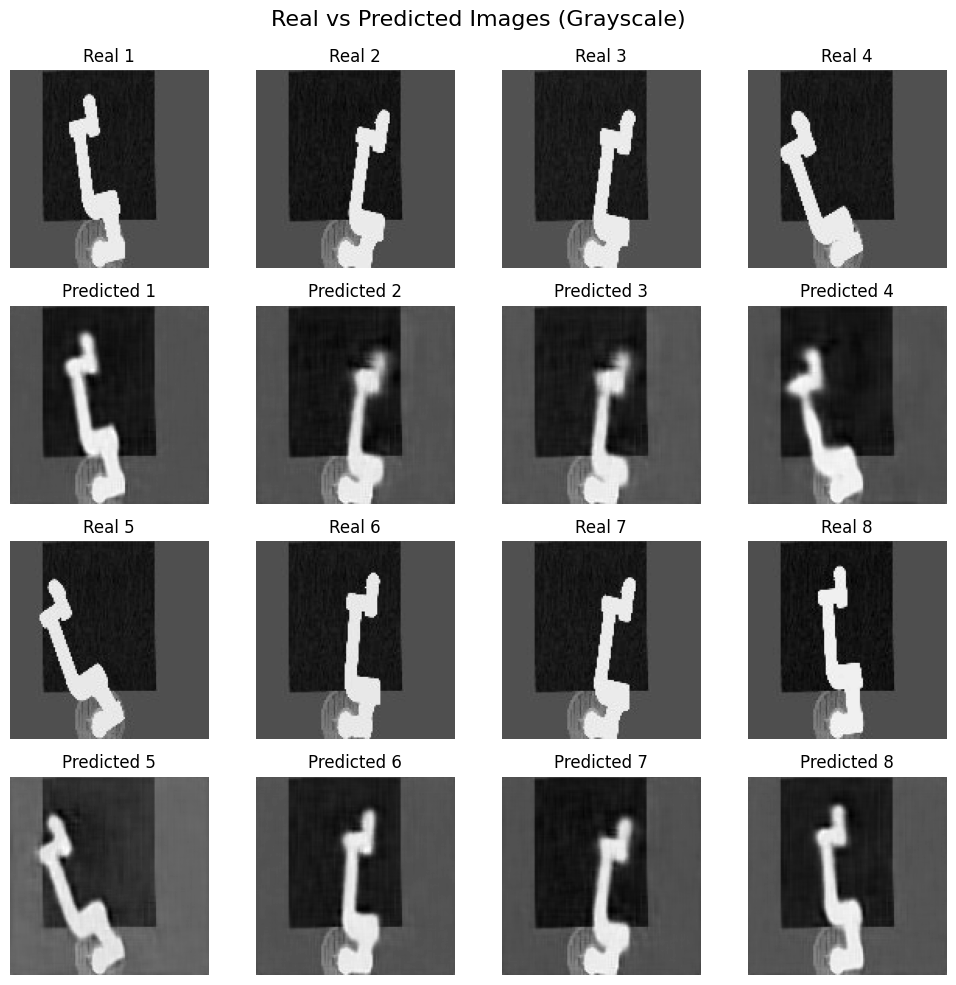

In [18]:
# Visualize reconstructed images
for data, labels in val_ds.take(1):
    img_input = data[0]
    joint_input = data[1]
    true_img = labels[0]
    true_joint = labels[1]

    # Predict reconstructions
    predicted_img, predicted_joint = decoder_model.predict({"image_input": img_input, "npy_input": joint_input})

# # Lấy một batch từ validation dataset
# for batch in val_ds.take(1):
#     (input_images, input_joints), (real_images, real_joints) = batch

# Convert tensor sang numpy array nếu cần
real_images = true_img.numpy()  # Ground truth (thực tế)
predicted_images = predicted_img  # Dự đoán (đã có sẵn dưới dạng numpy array)



def plot_real_vs_predicted(real_images, predicted_images, n=8):
    # # Lấy một batch từ validation dataset
    # for batch in val_ds.take(1):
    #     (input_images, input_joints), (real_images, real_joints) = batch

    # # Convert tensor sang numpy array nếu cần
    # real_images = real_images.numpy()
    # predicted_images = np.array(predicted_images)  # Convert predicted_images nếu cần
    
    # Đảm bảo n không vượt quá số lượng ảnh trong batch
    n = min(n, real_images.shape[0], predicted_images.shape[0])
    
    cols = min(4, n)  # Giới hạn số cột để giữ ảnh lớn hơn
    rows = (n + cols - 1) // cols  # Số hàng được tính tự động để vừa với n ảnh

    # Tạo một figure để hiển thị ảnh
    fig, axes = plt.subplots(2 * rows, cols, figsize=(10, 10))  # Gấp đôi số hàng để hiển thị cả ảnh thực tế và dự đoán
    fig.suptitle("Real vs Predicted Images (Grayscale)", fontsize=16)

    # Plot ảnh thực tế và dự đoán
    for i in range(n):
        # Plot ảnh thực tế
        ax_real = axes[2 * (i // cols), i % cols]  # Dòng chẵn: ảnh thực tế
        ax_real.imshow(real_images[i, :, :, 0], cmap='gray')
        ax_real.axis("off")
        ax_real.set_title(f"Real {i+1}")

        # Plot ảnh dự đoán
        ax_pred = axes[2 * (i // cols) + 1, i % cols]  # Dòng lẻ: ảnh dự đoán
        ax_pred.imshow(predicted_images[i, :, :, 0], cmap='gray')
        ax_pred.axis("off")
        ax_pred.set_title(f"Predicted {i+1}")

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Điều chỉnh tiêu đề không bị chèn lên các ảnh
    plt.show()

# Sử dụng hàm với n ảnh tùy chỉnh
plot_real_vs_predicted(real_images, predicted_images, n=8)



In [12]:
#decoder_model.save_weights("reconstruct.weights.h5")

In [13]:
decoder_model.summary()

Model: "DownstreamModelWithDecoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ npy_input           │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResNetImageNetwork  │ (None, 30)        │ 23,649,182 │ image_input[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ JointStateNetwork   │ (None, 10)        │         90 │ npy_input[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 40)        │          0 │ ResNetImageNetwo… │
│ (Concatenate)       │                   │            │ JointStateNetwor… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_space        │ (None, 20)        │        820 │ concatenate_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder             │ [(None, 128, 128, │    759,041 │ latent_space[0][… │
│ (Functional)        │ 1), (None, 8)]    │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,409,133 (93.11 MB)

 Trainable params: 24,356,013 (92.91 MB)

 Non-trainable params: 53,120 (207.50 KB)